In [1]:
using CoordinatedPrecoding, PyPlot, Compat

include(joinpath(dirname(@__FILE__), "../../../src/IAClustering.jl"))
using IAClustering;

INFO: Loading help data...


### Setup

In [2]:
include(joinpath(dirname(@__FILE__), "../simulation_params.jl"))
include(joinpath(dirname(@__FILE__), "../simulation_params-assignment_methods.jl"))
include(joinpath(dirname(@__FILE__), "../plot_params-assignment_methods.jl"))

simulation_params["independent_variable"] = (set_average_SNRs_dB!, 20)
simulation_params["aux_independent_variables"] = [
    ((n, v) -> set_aux_assignment_param!(n, v, "CoalitionFormationClustering:search_budget"), [100_000]),
    ((n, v) -> set_aux_network_param!(n, v, "num_coherence_symbols"), [num_coherence_symbols]),
    ((n, v) -> set_aux_network_param!(n, v, "beta_network_sdma"), [beta_network_sdma]),
]
simulation_params["Ndrops"] = 1
simulation_params["Nsim"] = 1;

### Network and raw layout plot

-- simulate on RandomLargeScaleNetwork(I = 12, Kc = 2, geography_size = (1611.854897735313,1611.854897735313), MS_serving_BS_distance = Nullable(150.0)).
--- Ndrops: 1, Nsim: 1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19

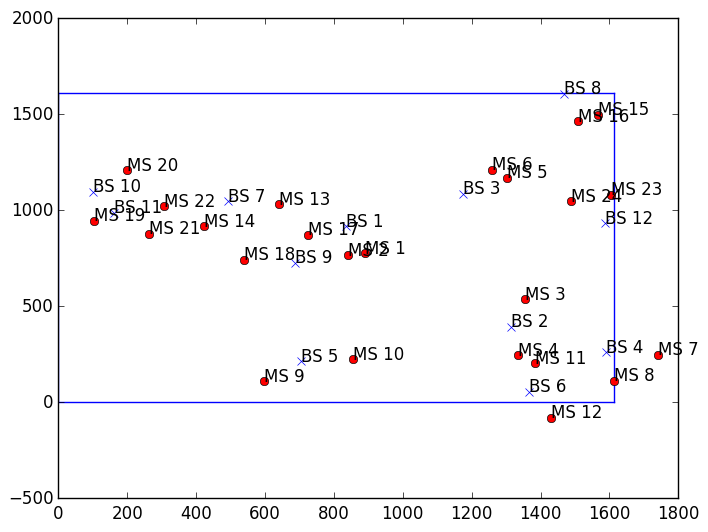

In [3]:
srand(1023723)
network =
    setup_random_large_scale_network(simulation_params["I"],
        simulation_params["Kc"], simulation_params["N"], simulation_params["M"],
        num_streams=simulation_params["d"],
        geography_size=simulation_params["geography_size"],
        MS_serving_BS_distance=simulation_params["MS_serving_BS_distance"])
raw_precoding_results, raw_assignment_results =
        simulate(network, simulation_params, loop_over=:assignment_methods)
plot_network_layout(network)

### Nicer plot

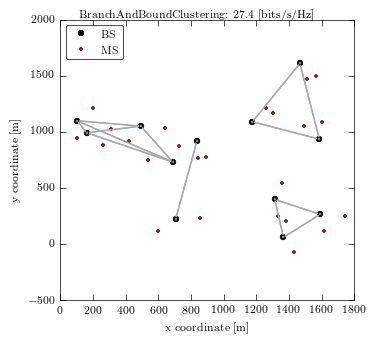

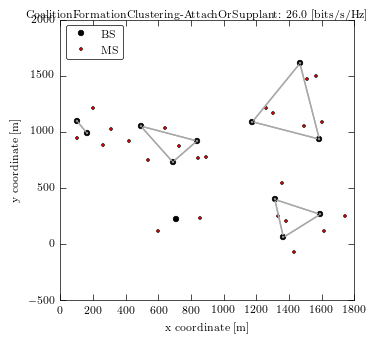

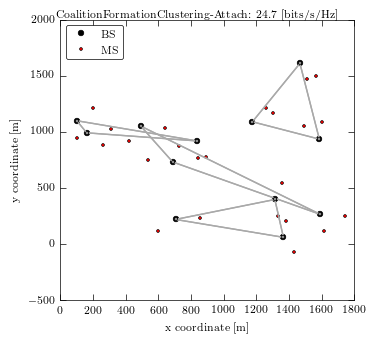

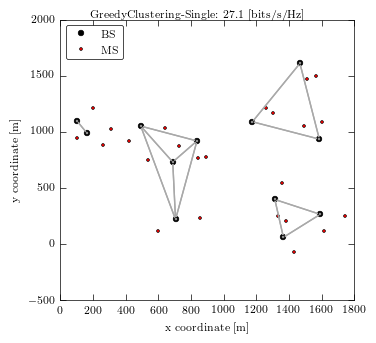

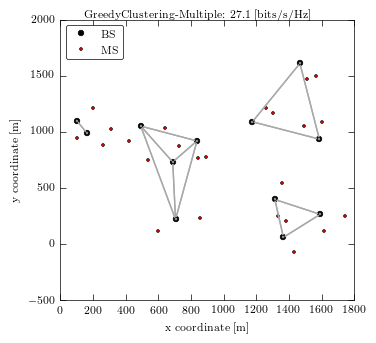

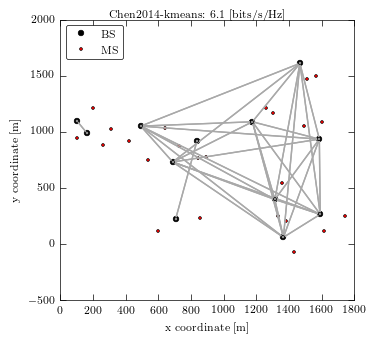

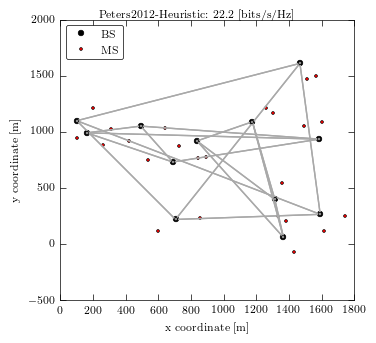

In [5]:
# Defaults
PyPlot.rc("lines", linewidth=1., markersize=3, markeredgewidth=0.5)
PyPlot.rc("font", size=8, family="serif", serif="Computer Modern Sans Serif")
PyPlot.rc("text", usetex=true)
PyPlot.rc("text.latex", preamble="\\usepackage{amsmath}")
PyPlot.rc("axes", linewidth=0.5, labelsize=8)
PyPlot.rc("xtick", labelsize=8)
PyPlot.rc("ytick", labelsize=8)
PyPlot.rc("legend", fancybox=true, fontsize=8)
PyPlot.rc("figure", figsize=(3.50,3.50), dpi=125)

I = get_num_BSs(network); K = get_num_MSs(network)

for method in [:BranchAndBoundClustering,
               :CoalitionFormationClustering_AttachOrSupplant,
               :CoalitionFormationClustering_Attach,
               :GreedyClustering_Single,
               :GreedyClustering_Multiple,
               :Chen2014_kmeans,
               :Peters2012_Heuristic]
    a = raw_assignment_results.simulation_results[1,1,1,1].precoding_results[string(method)]["a"]
    sum_throughput = sum(raw_assignment_results.simulation_results[1,1,1,1].precoding_results[string(method)]["throughputs"])
    partition = IAClustering.Partition(a)
    
    fig = PyPlot.figure()
    ax = fig[:add_axes]((0.11,0.15,0.95-0.11,0.95-0.15))

    # BSs
    global line_BS
    for i = 1:I
        pos = network.BSs[i].position
        line_BS = ax[:plot](pos.x, pos.y; marker="o", color="k", markersize=4, linewidth=0, label="BS")
    end

    # MSs
    global line_MS
    for k = 1:K
        pos = network.MSs[k].position
        line_MS = ax[:plot](pos.x, pos.y; marker="o", color="r", markersize=2, linewidth=0, label="MS")
    end

    # Annotations
    ax[:set_xlabel]("x coordinate [m]")
    ax[:set_ylabel]("y coordinate [m]")
    legend = ax[:legend](handles=[line_BS[1], line_MS[1]], loc="upper left", numpoints=1)
    legend_frame = legend[:get_frame]()
    PyPlot.setp(legend_frame, linewidth=0.5)

    # Save without cluster lines
    if method == :CoalitionFormationClustering_AttachOrSupplant
        fig[:savefig]("network_layout_example.eps")
    end

    # Show cluster lines
    for block in partition.blocks
        for i in block.elements
            for j in block.elements
                if i == j; continue; end
                pos1 = network.BSs[i].position; pos2 = network.BSs[j].position
                ax[:plot]([pos1.x, pos2.x], [pos1.y, pos2.y]; marker="o", color="DarkGray", markersize=2)
            end
        end
    end

    title = @sprintf "%s: %.1f [bits/s/Hz]" string(method) sum_throughput
    fig[:suptitle](replace(title, "_", "-"))
    display(fig)
end